<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/xception_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 64
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_all/train_cro/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_all/train_cro/molds_cro/4_9.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/4_10.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/4_11.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/4_12.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_1.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_2.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_3.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_4.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_5.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_6.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_7.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_8.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_9.jpg
/content/drive/My Drive/coffee_all/train_cro/molds_cro/5_10.jpg
/c

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

In [9]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)

### train test validate splite

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train_one_hot,test_size=0.33,shuffle=True,random_state=42,stratify=y_train_one_hot)

In [12]:
print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(3367, 64, 64, 3) ---- (3367, 6)
(1659, 64, 64, 3) ---- (1659, 6)


In [13]:
x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

### GoogleNet

In [14]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [15]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [16]:
input_layer = Input(shape=(64, 64, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [17]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [18]:
inp = Input(shape = (64,64,3))
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
#x = res_layer(x,32,dropout = 0.3)
x = res_layer(x,32,dropout = 0.4,pooling = True)
x = res_layer(x,64,dropout = 0.2)
x = res_layer(x,64,dropout = 0.2,pooling = True)
x = res_layer(x,256,dropout = 0.4)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(4096,activation = "relu")(x)
x = Dropout(0.23)(x)
x = Dense(6,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [19]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -5).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.25)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.40)(out)
out = Dense(256,activation='relu')(out)
out = Dropout(0.50)(out)

output = Dense(6,activation='softmax')(out)

In [20]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [21]:
e_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = e_model.fit([x_tr,x_tr],y_tr,epochs=100,validation_data=([x_v,x_v],y_v))

Epoch 1/100
106/106 [==============================] - 16s 91ms/step - loss: 1.3317 - accuracy: 0.4232 - val_loss: 4.9981 - val_accuracy: 0.2437
Epoch 2/100
106/106 [==============================] - 7s 69ms/step - loss: 0.9011 - accuracy: 0.6083 - val_loss: 1.4022 - val_accuracy: 0.3112
Epoch 3/100
106/106 [==============================] - 7s 69ms/step - loss: 0.7553 - accuracy: 0.6412 - val_loss: 1.3452 - val_accuracy: 0.4741
Epoch 4/100
106/106 [==============================] - 7s 69ms/step - loss: 0.6504 - accuracy: 0.7075 - val_loss: 1.7341 - val_accuracy: 0.5235
Epoch 5/100
106/106 [==============================] - 8s 71ms/step - loss: 0.5513 - accuracy: 0.7579 - val_loss: 1.0234 - val_accuracy: 0.6429
Epoch 6/100
106/106 [==============================] - 8s 71ms/step - loss: 0.5174 - accuracy: 0.8028 - val_loss: 0.4295 - val_accuracy: 0.8179
Epoch 7/100
106/106 [==============================] - 7s 70ms/step - loss: 0.4110 - accuracy: 0.8530 - val_loss: 0.5794 - val_accuracy

### plot the result

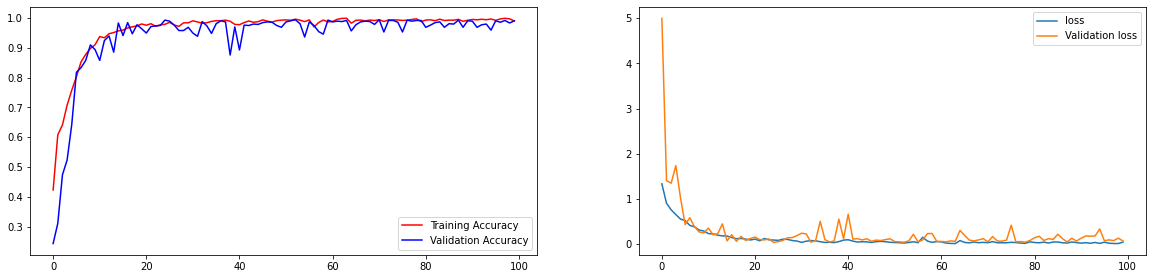

In [22]:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label= 'Validation Accuracy')
  #plt.title(f'Training and Validation accuray {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, loss,'', label = 'loss')
  plt.plot(epochs, val_loss,'', label = 'Validation loss')
  #plt.title(f'Training and Validation loss {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)
  #show the graph
  plt.show()

### make prdiction and do confusion matrix

### confusion matrix Training

In [23]:
pred_tr = e_model.predict([x_tr,x_tr])
round_pred_tr = np.argmax(pred_tr,axis=-1)
y_tr_r = np.argmax(y_tr,axis=-1)
#print("Acuracy of the Testing is : " ,pred)

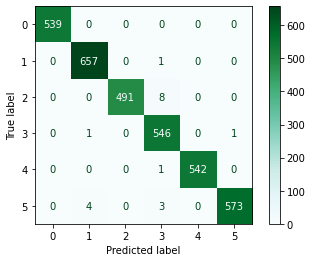

In [24]:
cm = confusion_matrix(y_tr_r, round_pred_tr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='BuGn')#BuGn,GnBu,Greens,YlOrBr
plt.show()

### validation confusion matrix

In [25]:
pred_v = e_model.predict([x_v,x_v])
round_pred_v = np.argmax(pred_v,axis=-1)
y_v_r = np.argmax(y_v,axis=-1)

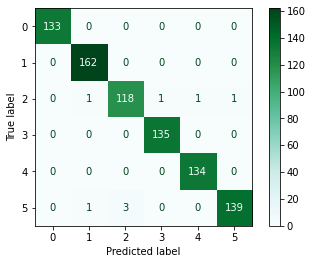

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       0.99      1.00      0.99       162
           2       0.98      0.97      0.97       122
           3       0.99      1.00      1.00       135
           4       0.99      1.00      1.00       134
           5       0.99      0.97      0.98       143

    accuracy                           0.99       829
   macro avg       0.99      0.99      0.99       829
weighted avg       0.99      0.99      0.99       829



In [26]:

cm = confusion_matrix(y_v_r, round_pred_v)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='BuGn')#BuGn,GnBu,Greens,YlOrBr
plt.show()
print(classification_report(y_v_r,round_pred_v))

### confusion matrix Testing

In [28]:
pred_t = e_model.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)

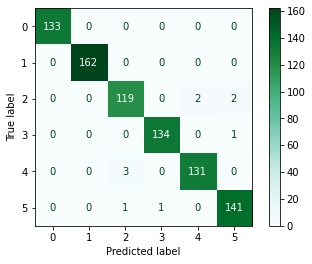

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      1.00      1.00       162
           2       0.97      0.97      0.97       123
           3       0.99      0.99      0.99       135
           4       0.98      0.98      0.98       134
           5       0.98      0.99      0.98       143

    accuracy                           0.99       830
   macro avg       0.99      0.99      0.99       830
weighted avg       0.99      0.99      0.99       830



In [29]:
cm = confusion_matrix(y_tes_r, round_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='BuGn')#BuGn,GnBu,Greens,YlOrBr
plt.show()
print(classification_report(y_tes_r,round_pred_t))